# **3_LDA Topic Modeling**  
references :  
https://codong.tistory.com/32  
https://han-py.tistory.com/283

<기본 단어>  
**말뭉치(Corpus)** : 특정한 목적을 가지고 수집한 텍스트 데이터  
**문서(Document)** : 문장(Sentence)들의 집합  
**문장(Sentence)** : 여러개의 토큰(단어, 형태소)로 구성된 문자열, 마침표, 느낌표 등의 기호로 구분  
**어휘집합(Vocabulary)** : 코퍼스에 있는 모든 문서, 문장을 토큰화하고 중복을 제거한 토큰의 집합  
**토큰(Token)** : 의미를 가진 가장 작은 단위  
**토큰화(Tokenization)** : 토큰단위를 나누는 것것

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

In [ ]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

In [4]:
import konlpy
from konlpy.tag import Kkma, Komoran, Hannanum, Okt
from konlpy.utils import pprint
from konlpy.tag import Mecab

In [6]:
m = Mecab()

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import sklearn as sk

In [8]:
import warnings
warnings.filterwarnings(action='ignore')

In [13]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [14]:
train = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/NLP_news_topic_classification/preprocessed_train.csv")
test = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/NLP_news_topic_classification/preprocessed_test.csv")

In [15]:
itsci = train[train["topic_idx"]==0]
econ = train[train["topic_idx"]==1]
society = train[train["topic_idx"]==2]
lifestyle = train[train["topic_idx"]==3]
world = train[train["topic_idx"]==4]
sports = train[train["topic_idx"]==5]
politic = train[train["topic_idx"]==6]

In [16]:
# 전처리 과정에서 불필요한 컬럼 생겨서 삭제 후 index 컬럼을 컬럼으로
train = train.drop(columns=["Unnamed: 0"])
test = test.drop(columns=["Unnamed: 0"])
train.set_index("index", inplace=True)
test.set_index("index", inplace=True)

## **Data Augmentation / Oversampling**    
references  
https://dacon.io/competitions/official/235747/codeshare/3050?page=1&dtype=recent  
https://dacon.io/competitions/official/235747/codeshare/3071?page=1&dtype=recent  

### Oversampling

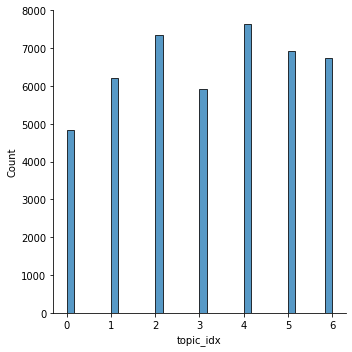

In [17]:
# 뉴스토픽별 비율 확인했을 때 차이 많이 안난다고 생각했었는데 아닌가보다 맞춰주는게 좋을 듯
# 소수 클래스 데이터 증가시킴 -> 데이터 불균형 처리 -> 정확도 증가
sns.displot(train.topic_idx)

In [18]:
from imblearn.over_sampling import RandomOverSampler

**SMOTE 오버샘플링**  
불균형 데이터의 문제를 해결  
소수 클래스 데이터 사이에 새로운 데이터를 생성하는 방식

In [19]:
# SMOTE : 오버샘플링
titles_t = train.title.to_numpy().reshape(-1, 1)
labels_t = train.topic_idx.to_numpy().reshape(-1, 1)
oversample = RandomOverSampler()
X_oversample, y_oversample = oversample.fit_resample(titles_t, labels_t)
train = pd.DataFrame({"title": X_oversample.reshape(-1), 'topic_idx': y_oversample.reshape(-1)})

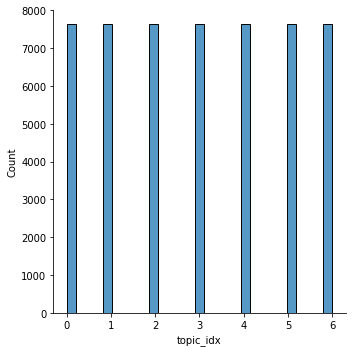

In [20]:
# SMOTE로 클래스별 비율 맞춰준 후 distplot
sns.displot(train.topic_idx)

### Data Augmentation  
references https://hong-yp-ml-records.tistory.com/103  
  
학습데이터 부족해서 데이터를 늘리거나 (크롤링한 데이터가 적을 때), 불균형 데이터의 레이블들의 균형을 잡아주기 위해 사용  
1. SR (Synonym Replacement) : 특정 단어를 유의어로 교체
2. RI (Random Insertion) : 임의의 단어를 삽입  
3. RS (Random Swap) : 텍스트 내 두 단어를 임의로 선정하여 서로 위치 바꾸기
4. RD (Random Delete) : 임의의 단어를 삭제  
  
+SMOTE 모듈로 진행한 oversampling과 다르게 클래스의 비율이 다르더라도 균형이 적절하다 판단되는 선에서 클래스 간 비율을 맞춰줄 수 있는 듯 하다.

## **주제별 토픽 모델링**  
references  
https://happy-obok.tistory.com/5
https://heytech.tistory.com/328
https://chaelist.github.io/docs/ml_application/topic_modeling/

**텍스트 기반의 문서 데이터에서 핵심 주제를 찾는 데이터 분석 방법론**  
- 문서 내에 어떤 토픽이, 어떤 비율로 구성되어 있는지 분석  
- 토픽별로 어떤 키워드가 구성되었는지 정보를 제공 -> 키워드 조합을 통해 인사이트 도출 가능  
  
*토픽별로 단어들이 어떻게 구성되어 있는지 알려주지만, 해당 토픽의 제목은 알려주지 않으므로 단어의 조합을 보고 토픽의 제목을 정해야함*    
  
**가정**
1. 문서 작성 시 사용할 최대 단어 개수 지정  
2. 확률 분포 기반하여 전체 문서 내 토픽별 비율 산출   
3. 단어가 토픽 분포에서 특정 토픽을 선택할 확률 산출  
4. 선택된 토픽에서 특정 단어가 출현할 확률 분포에 기반해 단어 선택   
5. 3.4번 과정 반복하여 문서 완성   
  
  
**과정**  
1. 토픽 개수 (하이퍼 파라미터) 결정 - k개의 토픽
2. 단어의 토픽 할당 : 문서 내의 모든 단어을 k개의 토픽 중 하나로 **임의로** 할당 -> 토픽 내 단어 분포의 결과는 틀린 상태  
3. 모든 단어에 대해 토픽을 재할당 : 같은 문서 내, 타 문서 내 단어의 토픽 분포 비교  
  
scikit-learn, genism 두 가지 방식으로 할 수 있음

### **1. Tokenization (한글 형태소 단위로 쪼개기기)**

In [22]:
import konlpy
import re

In [24]:
# tokenization 함수 생성
def tokenize_korean_text(text):
  okt = konlpy.tag.Okt()
  # okt.pos() : 각 품사를 태깅, 품사를 태깅 = 주어진 텍스트를 형태소 단위로 나누고, 나눠진 형태소를 해당 품사와 함께 리스트화
  Okt_morphs = okt.pos(text, stem=True)  # stem=True : 동사원형으로 바꿔서 return

  words = []
  for word, pos in Okt_morphs:
    if pos == "Adjecvie" or pos == "Verb" or pos == "Noun":  # 뉴스 특성상 명사, 동사만 남겨도 될 것 같긴 함
      words.append(word)

  words_str = ' '.join(words)
  return words_str
  

In [27]:
# train의 title 컬럼을 하나씩 tokenize해서 list로 저장
tokenized_list = []

for text in train["title"]:
  tokenized_list.append(tokenize_korean_text(text))

In [28]:
print(len(tokenized_list))

53403


In [29]:
print(tokenized_list[:5])

['인천 핀란드 항공기 결항 휴가 철 여행객 분통', '실리콘밸리 넘어서다 구글 들이다 미국 전역 거점', '이란 외무 긴장 완화 해결 책 미국 경제 전쟁 멈추다 것', '클린턴 측근 한국 기업 특수 관계 조명 공과 사 맞다 물리다', '시진핑 트럼프 중미 무역 협상 조속 타결 희망']


In [31]:
# 단어가 1-2개만 포함된 corpus는 삭제
drop_corpus = []

for index in range(len(tokenized_list)):
  corpus = tokenized_list[index]
  if len(set(corpus.split())) < 3: # 같은 단어 1-2개만 반복되는 corpus도 지우기 위해 set 씀 (중복 제거)
    train.drop(index, axis='index', inplace=True)
    drop_corpus.append(corpus)

for corpus in drop_corpus:
  tokenized_list.remove(corpus)

train.reset_index(drop=True, inplace=True)

In [34]:
print(len(tokenized_list))
print(len(train))

53128
53128


### **2. Vectorization & LDA**

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#### 1 ) vector화

**Vectorize (벡터화)**  
references : https://velog.io/@ljs7463/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%ACNLP-%ED%85%8D%EC%8A%A4%ED%8A%B8%EC%A0%84%EC%B2%98%EB%A6%AC%EB%B2%A1%ED%84%B0%ED%99%94  
  
자연어를 컴퓨터가 이해할 수 있도록 벡터로 만들어주는 것, 크게 두가지 방식  
1. 등장 횟수 기반의 단어 표현 : 단어가 문서/문장에 등장하는 횟수 기반으로 벡터화하는 방법   
ex ) Bag-of-Words, TR-IDF
  
2. 분포 기반의 단어 표현 : 타겟 단어 주변에 있는 단어를 벡터화하는 방법   
ex ) Word2Vec (Glove, fastText)

In [41]:
# LDA는 Count 기반의 Vectorizer만 적용 
count_vectorizer = CountVectorizer(max_features=1000, min_df=3, ngram_range=(1,3))
  # max_features : 포함시킬 최대 단어 수, 빈도 순으로 최대 1000단어까지만 포함시킴
  # min_df : 단어장에 포함되기 위한 최소 빈도, 3개 문서 미만으로 등장하는 단어는 제외
  # bigram, trigram까지 포함 -> 1-gram ~ 3-gram

feat_vect = count_vectorizer.fit_transform(tokenized_list)

In [42]:
print("CountVectorizer Shape :", feat_vect.shape)

CountVectorizer Shape : (53128, 1000)


#### 2 ) 토픽모델링 : LDA

In [43]:
lda = LatentDirichletAllocation(n_components = 7)  # 토픽의 개수는 우리가 분류해야하는 7개의 토픽으로 설정
lda.fit(feat_vect)

LatentDirichletAllocation(n_components=7)

#### 3 ) 토픽별 연관어 출력력

In [48]:
def display_topics(model, feature_names, num_top_words):
  for topic_index, topic in enumerate(model.components_):
    print("Topic #", topic_index)

    # components_array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array index를 반환
    topic_word_indexes = topic.argsort()[::-1] # components_array에서 값이 큰 순으로 정렬
    top_indexes = topic_word_indexes[:num_top_words] # num_top_words 개수 만큼 array index 반환

    # top_indexes 대상인 index별로 feature_names에 해당하는 word feature 추출후 join
    feature_concat = " ".join([feature_names[i] for i in top_indexes])
    print(feature_concat)

In [49]:
# CountVectorizer 객체 내의 전체 word들의 명칭을 get_features_names()를 통해 추출
feature_names = count_vectorizer.get_feature_names()

In [50]:
# Topic별 가장 연관도가 높은 word를 15개만만 추출
display_topics(lda, feature_names, 15)

Topic # 0
미국 되다 이란 중국 하다 세계 기업 확대 맞다 영국 시위 홍콩 찾다 협상 계약
Topic # 1
하다 대통령 박근혜 박근혜 대통령 한국 일본 청와대 게임 총리 방문 회의 대표 장관 여당 국회
Topic # 2
개발 기술 서비스 네이버 출시 삼성 사업 투자 하다 증권 전자 축구 결정 카카오 한국
Topic # 3
대다 전국 코스피 금융 하락 코로나 특징 대출 상승 추진 리그 최고 개막 가능성 소식
Topic # 4
하다 여행 한국 사망 터키 중국 독일 미국 올해 추다 공격 시리아 모바일 이탈리아 투자
Topic # 5
갤럭시 서울 삼성 증가 출시 영업 경기 현대 작년 감소 럭시 갤럭시 럭시 노트 연승 강원
Topic # 6
북한 하다 감독 보다 부산 대회 경기 월드컵 시즌 축제 한국 류현진 김정은 개최 방송


Topic # 0 : 세계, Topic # 1 : 정치, Topic # 2 : IT과학, Topic # 3 : 경제, Topic # 4 : 세계, Topic # 5 : IT과학, Topic # 6 : 스포츠   
+럭시는 갤럭시 토큰화하면서 그렇게 됐나  
+토픽별로 7가지 토픽이 다 안나오고 세계, IT과학이 2번씩 나옴, 그리고 몇몇 토픽은 한두단어가 주제에 맞지 않게 섞여 있음음



### **3. LDA 시각화 : pyLDAvis**

In [ ]:
!pip install pyLDAvis
import pyLDAvis.sklearn

In [56]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda, feat_vect, count_vectorizer)
pyLDAvis.display(vis)

시각화된 것을 보았을 때  
1+4+7 : 정치+세계 (7->4->1 : 세계 -> 정치)  
5 : 스포츠 (스포츠 세계랑 겹치는 단어 많으므로 7,4랑 가까움)  
6 : 경제(+세계)+생활  
3 : 경제+IT
2 : IT  
2, 3, 6 은 왜저렇게 되었는지 모르겠음

### **4. 문서별 토픽 할당**

#### 1 ) 각 문서별로 가장 가까운 topic으로 할당

In [57]:
# 문서별로, 가장 확률이 높은 topic으로 할당해줌 
doc_topic = lda.transform(feat_vect)

doc_per_topic_list = []
for n in range(doc_topic.shape[0]):
  topic_most_pr = doc_topic[n].argmax()
  topic_pr = doc_topic[n].max()
  doc_per_topic_list.append([n, topic_most_pr, topic_pr])

doc_topic_df = pd.DataFrame(doc_per_topic_list, columns=["Doc_Num", "Topic", "Percentage"])

doc_topic_df.head()

,Doc_Num,Topic,Percentage
0,0,2,0.380955
1,1,0,0.383572
2,2,0,0.519845
3,3,0,0.550266
4,4,0,0.857038


In [58]:
# 원래 train데이터에 join
doc_topic_df = doc_topic_df.join(train)
doc_topic_df.head()

,Doc_Num,Topic,Percentage,title,topic_idx
0,0,2,0.380955,인천에서핀란드 항공기 결항 휴가철 여행객 분통,4
1,1,0,0.383572,실리콘밸리 넘어서겠다 구글 15조원 들여 미국전역 거점화,4
2,2,0,0.519845,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,0,0.550266,NYT 클린턴 측근한국기업 특수관계 조명 공과 사 맞물려,4
4,4,0,0.857038,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


#### 2 ) 토픽별 문서 수 계산

In [59]:
doc_topic_df.groupby('Topic')[["Doc_Num"]].count()

,Doc_Num
Topic,
0,8096
1,9944
2,8151
3,6314
4,6674
5,6814
6,7135


#### 3 ) 토픽별로 가장 높은 확률로 할당된 문서 top5 확인

In [62]:
for topic in range(len(doc_topic_df["Topic"].unique())):
  print("Topic #", topic, "===============================")
  top_pr_topics = doc_topic_df[doc_topic_df['Topic']==topic].sort_values(by="Percentage", ascending=False)
  print(top_pr_topics["title"].iloc[0])
  print(top_pr_topics["title"].iloc[1])
  print(top_pr_topics["title"].iloc[2])
  print(top_pr_topics["title"].iloc[3])
  print(top_pr_topics["title"].iloc[4], '\n')

Topic # 0 ===============================
미국 무역협상 앞두고 홍콩 대만 장외카드로 중국 압박
중국매체 홍콩시위와 무역협상 연계하려는 미국 시도는 착각
이란 외무장관 미국 지원받아온 레바논 정부에 군사지원 용의
홍콩서 미국 홍콩 인권법안 통과 촉구 대규모 집회
집회 금지 수용못해 홍콩 시민 수만명 대규모 반대 송환법 시위 

Topic # 1 ===============================
푸틴 비핵화위해 북한체제안전보장해야 김정은 미국에 입장전달 요청
푸틴 비핵화위해 북한체제안전보장해야 김정은 미국에 입장전달 요청
문재인대통령 8일 국민경제자문회의 주재 일본 수출규제 대책 논의
박근혜대통령 3 1절 기념사 북핵포기 일본합의이행 강조 전망
평양정상회담 문재인 대통령 환영하는 평양 시민들 

Topic # 2 ===============================
언론진흥재단서울대 언론정보연구소 팩트체크 공동사업 추진
KT 대전진흥원과 5G 기반 영상데이터 관리기술 개발 추진
KT 대전진흥원과 5G 기반 영상데이터 관리기술 개발 추진
언론진흥재단 미디어교육 운영학교에 전문강사 등 지원
NH투자증권 중간배당 투자 유망주로 삼성전자 등 추천 

Topic # 3 ===============================
하루 만에 다시 달러 강세 원달러 환율 3.8원 상승
수출업체 월말 달러 매도에 원달러 환율 2.9원 하락 마감
연휴 전 수출업체 달러 매도에 원달러 환율 5.1원 하락
부동산대출규제 강화 첫날 은행창구 썰렁 대출 미리 신청
부동산대출규제 강화 첫날 은행창구 썰렁 대출 미리 신청 

Topic # 4 ===============================
사우디 예멘 반군 드론 격추 반군 사우디 공항 공격
예멘반군 사우디 군기지 공항 드론 공격 사우디 격추 주장
예멘반군 사우디 공항에 드론 공격 사우디 피해 없어
증시신상품 AB운용 미국 채권형 펀드에 투자하는 재간접 펀드
증시신상품 한국투자증권 연 7.6

뉴스 토픽 분류여서 LDA 토픽 모델링을 잘 몰랐을 때는 이름만 듣고 뉴스 토픽 분류 잘 해주지 않을까라고 생각했는데 보통 리뷰 분석에 많이 쓰이는 듯하다 + 파라미터튜닝을 다시 해봐야하나?